# Data Exploration Notebook

_For USD-599 Capstone Project by Hunter Blum, Kyle Esteban Dalope, and Nicholas Lee (Summer 2023)_

***

**Content Overview:**
1. Table Features
> Examining the dimension and features of each quarterly data scrape alone and when joined together.

> Mergining the quarterly data, Dropping duplicates (keeping only most recent values), and re-examining table features and dimensions.

2. Removal of Extraneous Variables
> Dropping variables not needed for EDA, based on domain knowledge.

3. Missing Value Evaluation and Handling

    3a. Handing Missing Values for the field _bathrooms_

4. EDA by Property Type

In [1]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

from uszipcode import SearchEngine, SimpleZipcode, ComprehensiveZipcode

In [2]:
# Set Output Display Options
'''
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)  
pd.set_option("display.max_rows", None)
'''

In [3]:
# Read in listings tables
june2022_listings_df = pd.read_csv("../Data/2022_06_june_listings.csv.gz", compression = "gzip")
sept2022_listings_df = pd.read_csv("../Data/2022_09_sept_listings.csv.gz", compression = "gzip")
dec2022_listings_df = pd.read_csv("../Data/2022_12_dec_listings.csv.gz", compression = "gzip")
mar2023_listings_df = pd.read_csv("../Data/2023_03_mar_listings.csv.gz", compression = "gzip")

# Sample Table
june2022_listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53661776,https://www.airbnb.com/rooms/53661776,20220615002624,2022-06-15,2 bedrooms/ 1 bath - Upstairs - Near Lake Hodges,"This listing consists of 2 bedrooms and 1 bath in the second story of our home. It is only 5 min away from Lake Hodges. The neighborhood is quiet and serene. Each room has a queen bed, large closet and AC. One of the rooms have a desk as well. This is perfect for a small family, or a small gathering. Guest have access to the kitchen. The backyard has hammocks and swings as well. <br /><br />Guest will be doing self-check in.<br /><br />Please note that the rooms are on the second floor, and there is no elevator.<br /><br /><b>The space</b><br />This area is in a very quiet neighborhood. We are super close to Lake Hodges and many other trails. <br /><br />There are 2 rooms in this listing - Each room has a queen bed. One of the rooms have a desk - perfect for workspace. There is one private bathroom for both rooms. This is perfect for small family or small gathering.<br /><br /><b>Guest access</b><br />Guess have access to the kitchen, to the backyard. The backyard has swings and hammoc",The neighborhood is very quiet and peaceful.,https://a0.muscache.com/pictures/miso/Hosting-53661776/original/c93aa25d-93d6-4903-adcc-c8e6343b7af6.jpeg,62320777,https://www.airbnb.com/users/show/62320777,Cara,2016-03-09,"San Diego, California, United States",Hi everybody! I'm Cara,within an hour,95%,97%,t,https://a0.muscache.com/im/pictures/user/2995cfb7-10a3-4b1d-a20d-c282a25ef58f.jpg?aki_policy=profile_small,https://a0.muscache.com/im/pictures/user/2995cfb7-10a3-4b1d-a20d-c282a25ef58f.jpg?aki_policy=profile_x_medium,Rancho Peñasquitos,7.0,7.0,"['email', 'phone']",t,t,"Escondido, California, United States",Rancho Bernadino,NaN,33.095280,-117.108360,Private room in home,Private room,4,NaN,1 private bath,2.0,2.0,"[""Dishwasher"", ""Wifi"", ""Dishes and silverware"", ""Room-darkening shades"", ""Body soap"", ""Kitchen"", ""Refrigerator"", ""Extra pillows and blankets"", ""Bathtub"", ""Hangers"", ""Hot water"", ""Dedicated workspace"", ""Cooking basics"", ""Keypad"", ""Shared fenced garden or backyard"", ""Shower gel"", ""Central heating"", ""Hot water kettle"", ""Wine glasses"", ""Carbon monoxide alarm"", ""TV"", ""Stove"", ""Outdoor furniture"", ""Dining table"", ""Clothing storage: closet"", ""BBQ grill"", ""Free parking on premises"", ""Essentials"", ""Free street parking"", ""Security cameras on property"", ""Air conditioning"", ""Smoke alarm"", ""Long term stays allowed"", ""Microwave"", ""Bed linens"", ""Hair dryer"", ""First aid kit"", ""Conditioner"", ""Shampoo"", ""Oven"", ""Lock on bedroom door""]",$167.00,2,60,2.0,3.0,112

## Table Features
Exploration of table shapes and features

In [4]:
# Individual Table Dimensions
def table_dim(df_shape):
    print("There are {} rows and {} columns".format(df_shape[0], df_shape[1]))

print("Table Dimensions for June 2022 Listings: ")
table_dim(june2022_listings_df.shape)
print("\nTable Dimensions for Sept. 2022 Listings: ")
table_dim(sept2022_listings_df.shape)
print("\nTable Dimensions for Dec. 2022 Listings: ")
table_dim(dec2022_listings_df.shape)
print("\nTable Dimensions for Mar. 2022 Listings: ")
table_dim(mar2023_listings_df.shape)

Table Dimensions for June 2022 Listings: 
There are 13272 rows and 74 columns

Table Dimensions for Sept. 2022 Listings: 
There are 14188 rows and 75 columns

Table Dimensions for Dec. 2022 Listings: 
There are 12781 rows and 75 columns

Table Dimensions for Mar. 2022 Listings: 
There are 12871 rows and 75 columns


The above inspection of listing dimensions reveals that after June 2022, a new, 75th column was added to the data collected.

In [5]:
# Get column names from each table
june_col = june2022_listings_df.columns
sept_col = sept2022_listings_df.columns
dec_col = dec2022_listings_df.columns
mar_col = mar2023_listings_df.columns


print(sept_col.difference(june_col))
print(sept_col.difference(dec_col))
print(sept_col.difference(mar_col))

Index(['source'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


The new column added after June 2022, was called "source."

In [6]:
sept2022_listings_df["source"].describe()

count           14188
unique              2
top       city scrape
freq            12956
Name: source, dtype: object

In [7]:
dec2022_listings_df["source"].describe()

count           12781
unique              2
top       city scrape
freq            11589
Name: source, dtype: object

In [8]:
mar2023_listings_df["source"].describe()

count           12871
unique              2
top       city scrape
freq            11644
Name: source, dtype: object

Within the _source_ column, there are two unique values, where one value dominates the majority of records (e.g. in records for the quarter up until March 2023, the predominant source value occupied 11,644 of 12,871 records). In planning for future machine learning applications, such a column would not be greatly informative. Therefore, it can be removed, and the tables may be joined along the unique house id.

### Dropping "source" column

In [9]:
# Removing the source column
sept2022_listings_df = sept2022_listings_df.drop(columns="source", axis = 1)
dec2022_listings_df = dec2022_listings_df.drop(columns = "source", axis = 1)
mar2023_listings_df = mar2023_listings_df.drop(columns = "source", axis = 1)

## Combining all tables into one dataframe
The four quarterly tables are concatenated to form one dataframe. Then, duplicates from the _id_ column are removed, keeping the last, most recent, up-to-date entry for each listing.

In [10]:
# Combine all four dataframes into one
all_data = pd.concat([june2022_listings_df, sept2022_listings_df,
                        dec2022_listings_df, mar2023_listings_df])

In [11]:
# Convert last_scraped column to datetime data type
all_data["last_scraped"] = pd.to_datetime(all_data["last_scraped"])

In [12]:
# Sort by date and drop duplicates (keeping most recent entries)
all_data_no_dupes = all_data.sort_values(
    "last_scraped").drop_duplicates(["id"], keep = "last")

## Merged Dataframe Descriptive Statistics

In [13]:
# Check new dataframe dimensions
all_data_no_dupes.shape

(18627, 74)

## Removing Extraneous Variables
To ease the EDA process, extraneous variables, determined to be impertinent to price determination, were removed using domain knowledge.

#### **Remove chart below after deciding which column to drop

<AxesSubplot: ylabel='Frequency'>

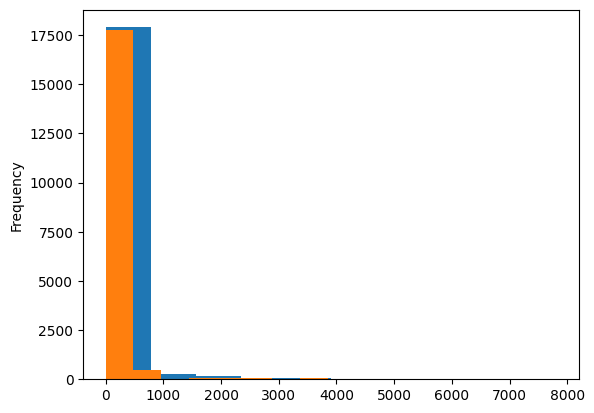

In [14]:
all_data_no_dupes["host_total_listings_count"].plot.hist()
all_data_no_dupes["host_listings_count"].plot.hist()

**host_listings_count and host_total_listings_count appear to be the same

In [15]:
# Drop one of the above variables in the chart
eda_subset = all_data_no_dupes.drop(
    columns = ["scrape_id", "listing_url", "host_id", "host_url", "host_name", 
               "host_since", "host_location", "host_about", "host_response_time", 
               "host_response_rate", "host_acceptance_rate", "host_is_superhost", 
               "host_thumbnail_url", "host_picture_url", "host_verifications",
               "host_has_profile_pic", "host_identity_verified"], 
    axis = 1
)

In [16]:
# Descriptive Statistics of a Select Subset of Features
eda_subset.describe().T

,count,mean,min,25%,50%,75%,max,std
id,18627.0,244970506009365984.0,6.0,29943733.0,49818439.0,628769716496820864.0,853653678315646848.0,333476445445733504.0
last_scraped,18627,2023-01-27 14:34:06.706393856,2022-06-15 00:00:00,2022-12-24 00:00:00,2023-03-25 00:00:00,2023-03-25 00:00:00,2023-03-25 00:00:00,NaN
host_listings_count,18576.0,84.257321,0.0,1.0,4.0,20.0,4807.0,374.064936
host_total_listings_count,18576.0,121.971307,0.0,2.0,5.0,29.0,7816.0,525.94779
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,18627.0,32.763184,32.51986,32.718332,32.75485,32.798349,33.12569,0.092287
longitude,18627.0,-117.172498,-117.28258,-117.246039,-117.16462,-117.129225,-116.89656,0.073437
accommodates,18627.0,4.815483,0.0,2.0,4.0,6.0,16.0,3.168323
bathrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,17089.0,1.985195,1.0,1.0,2.0,3.0,34.0,1.289118


## Missing Values Evaluation

In [17]:
# Examine Which Features Have Missing Values
eda_subset.isnull().sum().to_frame(name = "Missing_Value_Count").query("Missing_Value_Count > 0")

,Missing_Value_Count
description,138
neighborhood_overview,6735
host_neighbourhood,2449
host_listings_count,51
host_total_listings_count,51
neighbourhood,6735
neighbourhood_group_cleansed,18627
bathrooms,18627
bathrooms_text,6
bedrooms,1538


In [18]:
# Look at columns with missing values for every record
eda_subset.isnull().sum().to_frame(name = "Missing_Value_Count").query("Missing_Value_Count == 18627")

,Missing_Value_Count
neighbourhood_group_cleansed,18627
bathrooms,18627
calendar_updated,18627


3 columns, _neighbourhood_group_cleansed_, _bathrooms_, and _calendar_updated_, are missing values for every single row. While, _neighbourhood_group_cleansed_ and _calendar_updated_ may be dropped, as their information is not especially key to determining price, the number of _bathrooms_ is key.

_bathrooms_text_ is a text version of the the numerical bathrooms column. _Bathrooms_text_ can be used to fill the missing values for _bathrooms_.

### Filling _bathrooms_ Missing Values with Values from _bathrooms_text_

In [19]:
# Sample of text data used to fill numerical field
eda_subset[["bathrooms", "bathrooms_text"]].head(5)

,bathrooms,bathrooms_text
8853,NaN,2 baths
8839,NaN,1.5 baths
8838,NaN,1 bath
8819,NaN,1 private bath
8823,NaN,1 private bath


In [20]:
# Function to extract integers and floats from text
def bath_number(text):
    try:
        num_baths = re.search("[\d.]", text).group()
        # Returns integer or float
        return num_baths
    except:
        # If no value could be returned
        # Return a missing value placeholder
        return np.nan

# Apply function to bathroom_text column to fill bathrooms column
eda_subset["bathrooms"] = eda_subset["bathrooms_text"].apply(
    lambda x: bath_number(x)
)


In [21]:
# Assess bathroom values that could not be filled
eda_subset[eda_subset["bathrooms"].isnull()]["bathrooms_text"].value_counts()
# Text descriptions that do not contain numerical text will have to be filled manually

bathrooms_text
Private half-bath    69
Half-bath            16
Shared half-bath      6
Name: count, dtype: int64

In [22]:
# Fill missing bathroom values based on text values
eda_subset.loc[eda_subset["bathrooms_text"] == "Private half-bath", ["bathrooms"]] = 0.5
eda_subset.loc[eda_subset["bathrooms_text"] == "Half-bath", ["bathrooms"]] = 0.5
eda_subset.loc[eda_subset["bathrooms_text"] == "Shared half-bath", ["bathrooms"]] = 0.5

In [23]:
# After imputing the bathroom values with _bathroom_text_,
# Only 6 missing values for bathrooms remain
eda_subset["bathrooms"].isnull().sum()

6

## EDA by Property Type

In [24]:
all_data_no_dupes["property_type"].value_counts()

property_type
Entire home                           5113
Entire rental unit                    3742
Entire condo                          2839
Private room in home                  1465
Entire guesthouse                      799
Entire guest suite                     628
Entire townhouse                       590
Private room in rental unit            501
Entire serviced apartment              345
Entire cottage                         339
Private room in condo                  288
Room in hotel                          261
Entire loft                            216
Entire bungalow                        215
Private room in townhouse              170
Entire villa                           123
Camper/RV                              122
Private room in guest suite            109
Room in boutique hotel                 102
Entire vacation home                    86
Tiny home                               48
Shared room in hostel                   47
Private room in bed and breakfast       

- New binary column (property_type_binary) - Values are either room or house
- New binary column private (0 - not a private room (i.e. shared room), 1 - private)

## Zip Code and Median Income Feature Creation
From the given longitude and latitude coordinates, find the zip code of the rental property. Then, add a new column _median_income_ for the median income of the zip code, using census data.

**I think we might want to move this section to Preprocessing/Feature Enginnering - but I'm not sure because we also need it for EDA**

In [31]:
# Set up a search engine
search = SearchEngine()

# Function to search for a zip code based on a coordinate pair
def get_zipcode(lat, lon):
    result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
    return result[0].zipcode

# Create a new column _zipcode_ and apply the get_zipcode function
## This takes a few minutes to complete
eda_subset['zipcode'] = eda_subset.apply(lambda x: get_zipcode(x["latitude"], x["longitude"]), axis=1)

Download C:\Users\Nick\.uszipcode\simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


In [34]:
eda_subset["zipcode"]

8853     92109
8839     92120
8838     92103
8819     92037
8823     92109
8826     92101
8865     91932
8866     92129
8730     92101
8731     92101
8791     92037
8795     92101
8798     92103
8799     92103
8802     92014
8808     92101
8786     92101
8766     92102
8785     91950
8918     92101
9051     92107
9028     92107
9087     92126
8949     92101
8954     92101
8965     92107
8920     92117
8924     92037
8942     92107
8931     92101
9009     92130
9017     92037
8995     92037
8971     92107
8973     92108
8984     92101
8439     92105
8442     92037
8411     92107
8414     92103
8416     92113
8449     92126
8480     92120
8482     92115
8486     92115
8487     92115
8477     92120
8490     92115
8492     92120
8493     92120
8494     92120
8495     92120
8496     92120
8497     92120
8489     92115
8457     92120
8460     92109
8464     92120
8469     92120
8472     92120
8325     92120
8329     92115
8336     92101
8338     92037
8339     92120
8342     92113
8343     9

## Export Results

In [ ]:
# eda_subset.to_csv("../Data/lyrics.csv.gz", compression = "gzip")